In [1]:
using DifferentialEquations
using Plots
using DataFrames
using Peaks #For detecting oscillations
using Random
using Polyhedra #For creating convex hulls
using QHull #For creating convex hulls
using Surrogates
using AbstractGPs
using SurrogatesAbstractGPs

In [79]:
#Define ODE model and solve
"""ode(du, u, t)
        Defines a system of differential equations for a 2D regulon with multiple steady states 
""" 
function ode(du, u, p, t)
    du[1] = (1.95*u[1]^3)/(1+u[1]^3) + (9*u[2]^3)/(6^3 + u[2]^3) - u[1]
    du[2] = (10*u[1]^3)/(7^3 + u[1]^3) + (1.95*u[2]^3)/(1+u[2]^3) - u[2]
end

"""solve_ode(u0)
        Integrates ODE system and returns the solution.
""" 
function solve_ode(u0, endtime=1E4, resolution=200)
    tspan = [0, endtime] #Span of time to integrate for
    savetimes = LinRange(0, endtime, resolution) #linear space of points until final time
    p = []
    prob = ODEProblem(ode, u0, tspan, p)
    sol = solve(prob, Tsit5(), reltol=1e-3, abstol=1e-6, saveat=savetimes)
    return sol
end 

#Sample parameter space
"""initial_sampling(lower_bounds, upper_bounds, n_init)
        Returns n_init samples between lower_bounds and upper_bounds. 
        If dimensionality is less than 7, also returns corner samples.
""" 
function initial_sampling(lower_bounds, upper_bounds, n_init)
    #Sample uniform points across space
    n_dims = length(lower_bounds)
    samples = Matrix{Float64}(undef, n_init, n_dims)
    for d in 1:n_dims
        lb = lower_bounds[d]
        ub = upper_bounds[d]
        for i in 1:n_init
            samples[i, d] = rand() * (ub - lb) + lb
        end
    end

    # if n_dims<7 #Maximum dimension for corner sampling is 7D (N=128 vertices)
    #     #Sample corners
    #     get_hyperrectangle_vertices = (lower_bounds, upper_bounds) -> [ [bounds[(i ÷ 2^d) & 1 + 1] for (d, bounds) in enumerate(zip(lower_bounds, upper_bounds))] for i in 0:(2^length(lower_bounds)-1) ]
    #     corners = hcat(get_hyperrectangle_vertices(lower_bounds, upper_bounds)...)'
    # end

    # return vcat(samples, corners)
    return samples
end

#Solve ODE and score
"""compute_classes(samples::Matrix(NxD))
        Given a set of initial conditions (samples), computes the steady state and converts to a string identifier for the class
"""
function compute_classes(samples)
    return [class_name(solve_ode(samples[i, :]).u[end]) for i in 1:size(samples)[1]]
end

function class_name(ss)
    return string(round(abs(ss[1]), digits=1))*", "*string(round(abs(ss[2]), digits=1))
end

function create_convex_hull(points)
    #Instantiates list of convex hulls based on a set of points 
    #Returns hull and convex hull metric
    hull = chull(mapreduce(permutedims, vcat, points))
    return hull, hull.volume
end

function create_hulls_and_compute_volume(classes, samples)
    hulls = []
    total_volume = 0
    for c in unique(classes)
        class_indices = findall(x -> x == c, classes)
        hull_points = samples[class_indices, :]
        hull_points = [row[:] for row in eachrow(hull_points)]
        if length(class_indices) >= 3
            hull, vol = create_convex_hull(hull_points)
            total_volume = vol + total_volume
            push!(hulls, hull)
        end
    end
    return hulls, total_volume
end

#Remove each point and inflate convex hulls to score
function one_out_scoring(samples, classes)
    scores = []
    temp_hulls = []
    for i in 1:size(samples)[1]
        rem_samples = vcat(samples[1:i-1, :], samples[i+1:end, :])
        rem_classes = vcat(classes[1:i-1], classes[i+1:end])
        total_volume = 0
        for ss in unique(classes)
            class_indices = findall(x -> x == ss, rem_classes)
            hull_points = rem_samples[class_indices, :]
            hull_points = [row[:] for row in eachrow(hull_points)]
            if length(class_indices) >= 3
                hull, vol = create_convex_hull(hull_points)
                push!(temp_hulls, hull)
                total_volume = vol + total_volume
            end
        end
        push!(scores, total_volume)
    end
    return scores
end

#Fit nonparametric MODEL
function fit_model(samples, scores)
    training_samples = [Tuple(row[:]) for row in eachrow(samples)]
    training_scores = [Float64(score) for score in scores]
    return AbstractGPSurrogate(training_samples, training_scores)
end

#Determine next sample balancing exploration/exploitation
function sampling(n_rand)
    return 10*rand(n_rand, 2)
end

function computeCentroid(verts)
    n = length(verts)
    A = 0.0 # Area of the polygon
    Cx = 0.0 # x-coordinate of the centroid
    Cy = 0.0 # y-coordinate of the centroid

    for i in 1:(n-1)
        common_term = verts[i][1] * verts[i+1][2] - verts[i+1][1] * verts[i][2]
        A += common_term
        Cx += (verts[i][1] + verts[i+1][1]) * common_term
        Cy += (verts[i][2] + verts[i+1][2]) * common_term
    end

    A /= 2.0
    Cx /= (6.0 * A)
    Cy /= (6.0 * A)

    return [Cx, Cy]
end

function euclideanDistance(point1::Vector{Float64}, point2::Vector{Float64})::Float64
    return sqrt(sum((point1 - point2) .^ 2))
end

function acquisition_function(data, verts)
    # #Scores a set of points with a preexisting model
    # scores = []
    # for i in 1:size(data)[1]
    #     ic = Tuple(data[i, :])
    #     push!(scores, model(ic))
    # end
    # return scores

    #Compute centroids of hulls from vertices
    centroids = []
    for i in 1:length(verts)
        push!(centroids, computeCentroid(verts[i]))
    end

    scores = []
    for i in 1:size(data)[1]
        score = 0
        for j in 1:length(centroids)
            score += euclideanDistance(centroids[j], data[i, :])

            #Check if point is in convex hull
            hull_points = vcat(verts[j], [data[i, :]])
            new_hull, new_vol =  create_convex_hull(hull_points)
            old_hull, old_vol =  create_convex_hull(verts[j])
            if new_vol <= old_vol
                score -= 10E7 #Add penalty if point is inside hull
            end
        end
        
        push!(scores, score)
    end
    return scores
end

function extract_hull_vertices(hulls)
    verts_total = []
    for j in 1:length(hulls)
        verts = [hulls[j].points[i, :] for i in hulls[j].vertices]
        push!(verts, verts[1, :][1])
        push!(verts_total, verts)
    end
    return verts_total
end

function scan_steady_states(n_init=25, n_iters=100, n_rand=100, n_best=1, kernel=0)
    sample_data = DataFrame()
    options_data = DataFrame()

    #Define search space
    lower_bounds = [0., 0.]
    upper_bounds = [10., 10.]
    space_size = prod(upper_bounds .- lower_bounds)

    #Initial sampling
    samples = initial_sampling(lower_bounds, upper_bounds, n_init)
    
    #Solve ODE at initial samples
    classes = compute_classes(samples)

    #If all are same steady-state, exit and conclude no multistability
    if length(unique(classes)) < 2 return "Unistable system" end
    
    #Else, score points based on leave-one-out convex hulls
    scores = one_out_scoring(samples, classes)

    sample_data = vcat(sample_data, DataFrame("x" => samples[:,1], "y" => samples[:,2], "score" => scores, "class" => classes, "conv" => fill("initial", length(classes))))

    #Create current total hulls
    total_scores = []
    hulls, total_volume = create_hulls_and_compute_volume(classes, samples)
    verts = extract_hull_vertices(hulls)
    push!(total_scores, total_volume)

    #Train a GPR on sample/score pairs
    model = fit_model(samples, scores)

    #Bayesian loop
    for i in 1:n_iters
        if total_scores[end]/space_size > 0.9
            break #Stop loop if reached 90% coverage
        end
    
        #Sample from posterior and select next sample
        init_values_options = sampling(n_rand) #Sampling function, can be changed
        score_options = acquisition_function(init_values_options, verts) #Score possible options
        next_sample = init_values_options[argmax(score_options), :] #Select best possible options

        options_data = vcat(options_data, DataFrame("x" => init_values_options[:, 1], "y" => init_values_options[:, 2], "pred_score" => score_options, "iter" => fill(i, n_rand)))

        next_result = solve_ode(next_sample)
        next_class = compute_classes(next_result)[1]

        samples = vcat(samples, next_sample')
        classes = push!(classes, next_class)

        #Recompute hulls
        total_scores = []
        hulls, total_volume = create_hulls_and_compute_volume(classes, samples)
        verts = extract_hull_vertices(hulls)
        push!(total_scores, total_volume)
        push!(scores, total_volume)

        sample_data = vcat(sample_data, DataFrame("x" => [next_sample[1]], "y" => [next_sample[2]], "score" => [total_scores[end]], "class" => [next_class], "conv" => [100*total_scores[end]/space_size]))

        #Refit GPR with new score
        model = fit_model(samples, scores)

    end
    final_hulls, final_volume = create_hulls_and_compute_volume(classes, samples)
    final_verts = extract_hull_vertices(final_hulls)
    return sample_data, final_hulls, final_verts, options_data
end

scan_steady_states (generic function with 6 methods)

In [80]:
sample_data, final_hulls, final_verts, options_data = scan_steady_states(10, 250, 25)
# using CSV
# CSV.write("2d_sample_run.csv", sample_data)

(70×5 DataFrame
 Row │ x         y          score    class     conv    
     │ Float64   Float64    Any      String    Any     
─────┼─────────────────────────────────────────────────
   1 │ 2.29958   5.499      27.1013  2.1, 2.0  initial
   2 │ 9.65813   0.684408   23.8816  2.1, 2.0  initial
   3 │ 1.70914   7.85078    21.0614  2.1, 2.0  initial
   4 │ 8.33527   1.75409    27.1013  2.1, 2.0  initial
   5 │ 1.09531   6.74       24.9518  2.1, 2.0  initial
   6 │ 9.65834   1.42479    27.1013  8.5, 8.4  initial
   7 │ 5.19927   0.160867   21.7872  2.1, 2.0  initial
   8 │ 4.26567   3.66155    27.1013  2.1, 2.0  initial
  ⋮  │    ⋮          ⋮         ⋮        ⋮         ⋮
  64 │ 9.75877   0.0385041  87.0684  8.5, 8.4  87.0684
  65 │ 8.57822   9.97103    87.0727  8.5, 8.4  87.0727
  66 │ 2.69156   9.88092    87.2446  8.5, 8.4  87.2446
  67 │ 2.08905   9.72033    89.3651  2.1, 2.0  89.3651
  68 │ 1.34961   0.0311906  89.5347  2.1, 2.0  89.5347
  69 │ 9.91144   1.01163    89.54    8.5, 8.4  89

In [78]:
function acquisition_function(data, verts)
    # #Scores a set of points with a preexisting model
    # scores = []
    # for i in 1:size(data)[1]
    #     ic = Tuple(data[i, :])
    #     push!(scores, model(ic))
    # end
    # return scores

    #Compute centroids of hulls from vertices
    centroids = []
    for i in 1:length(verts)
        push!(centroids, computeCentroid(verts[i]))
    end

    scores = []
    for i in 1:size(data)[1]
        score = 0
        for j in 1:length(centroids)
            score += euclideanDistance(centroids[j], data[i, :])

            #Check if point is in convex hull
            hull_points = vcat(verts[j], [data[i, :]])
            new_hull, new_vol =  create_convex_hull(hull_points)
            old_hull, old_vol =  create_convex_hull(verts[j])
            if new_vol <= old_vol
                score -= 10E7 #Add penalty if point is inside hull
            end
        end
        
        push!(scores, score)
    end
    return scores
end

acquisition_function(sampling(25), final_verts)

25-element Vector{Any}:
 -9.999997752768523e7
 -9.999998074127732e7
 -9.999998027592793e7
 -9.999997691280138e7
 -9.99999704549254e7
 -9.999997717059533e7
 -9.999997714067614e7
 -9.999997130789031e7
 -9.999997818661258e7
 -9.999997574571477e7
  ⋮
 -9.999997981277832e7
 -9.999997736074568e7
 31.625407083915285
 -9.999996625800791e7
 -9.99999717605369e7
 -9.999997420339675e7
 -1.9999996901790744e8
 -9.999997694080369e7
 -9.999997881290781e7

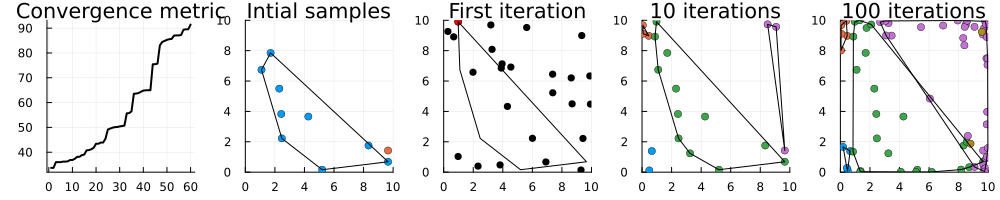

Total domains of attraction found: 5
Locations of stable steady states: ["2.1, 2.0", "8.5, 8.4", "0.1, 1.5", "0.0, 0.0", "8.6, 8.4"]


In [81]:
using Plots
using DataFrames
using StatsPlots # For scatter plot with groups

not_initial = filter(row -> row[:conv] != "initial", sample_data)
initial = filter(row -> row[:conv] == "initial", sample_data)

# Assuming 'data' is a DataFrame in Julia with columns :class and :score
classes = unique(sample_data[!, :class])
scores = not_initial[!, :score]

println("Total domains of attraction found: ", length(classes))
println("Locations of stable steady states: ", classes)

# Convergence metric
p1 = plot(scores, ylabel="Convex Hull Volume", xlabel="Iterations of BayesOpt", legend=false, color=:black, lw=2, title="Convergence metric")
ylabel!(p1, "Convex Hull Volume", fontsize=15)
xlabel!(p1, "Iterations of BayesOpt", fontsize=15)

# Initial samples
p2 = scatter(initial[!, :x], initial[!, :y], group=initial[!, :class], legend=false, xlim=(0, 10), ylim=(0, 10), title="Intial samples")

hulls, vol = create_hulls_and_compute_volume(initial.class, hcat(initial.x, initial.y))
verts = extract_hull_vertices(hulls)
for k in 1:length(verts)
    x_verts = [vec[1] for vec in verts[k]]
    y_verts = [vec[2] for vec in verts[k]]

    plot!(p2, x_verts, y_verts, color="black")
end

# First sample iteration 
firstiter = filter(row -> row[:iter] == 1, options_data)
next_sample = firstiter[firstiter.pred_score .== maximum(firstiter.pred_score), :]

p3 = scatter([firstiter[!, :x], next_sample[!, :x]], [firstiter[!, :y], next_sample[!, :y]], legend=false, color=["black" "red"], xlim=(0, 10), ylim=(0, 10), title="First iteration")

first1 = sample_data[findall(x -> x in 1:nrow(initial)+1, 1:nrow(sample_data)), :]
hulls, vol = create_hulls_and_compute_volume(first1.class, hcat(first1.x, first1.y))
verts = extract_hull_vertices(hulls)
for k in 1:length(verts)
    x_verts = [vec[1] for vec in verts[k]]
    y_verts = [vec[2] for vec in verts[k]]
    plot!(p3, x_verts, y_verts, color="black")
end

# plot!(p3, scatter(next_sample[!, :x], next_sample[!, :y], legend=false), color="red")
# first10 = sample_data[findall(x -> x in nrow(initial):nrow(initial)+10, 1:nrow(sample_data)), :]
# p3 = scatter(first10[!, :x], first10[!, :y], group=first10[!, :class], legend=false)

# First 100 iterations
first100 = sample_data[findall(x -> x in 1:nrow(initial)+10, 1:nrow(sample_data)), :]
p4 = scatter(first100[!, :x], first100[!, :y], group=first100[!, :class], legend=false, xlim=(0, 10), ylim=(0, 10), title="10 iterations")
hulls, vol = create_hulls_and_compute_volume(first100.class, hcat(first100.x, first100.y))
verts = extract_hull_vertices(hulls)
for k in 1:length(verts)
    x_verts = [vec[1] for vec in verts[k]]
    y_verts = [vec[2] for vec in verts[k]]
    plot!(p4, x_verts, y_verts, color="black")
end

# All 1000 iterations
p5 = scatter(sample_data[!, :x], sample_data[!, :y], group=sample_data[!, :class], legend=false, xlim=(0, 10), ylim=(0, 10), title="100 iterations")
for k in 1:length(final_verts)
    x_verts = [vec[1] for vec in final_verts[k]]
    y_verts = [vec[2] for vec in final_verts[k]]
    plot!(p5, x_verts, y_verts, color="black")
end

# Combine plots
final_plot = plot(p1, p2, p3, p4, p5, layout=(1,5), size=(1000,200))

# Display the plot
display(final_plot)

In [49]:
savefig(final_plot, "test_run.png")

"/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/sampling-networks/hiscock_model/test_run.png"

In [ ]:
#centroid of convex hull and then sample maximally far away from the sample. 
#how expensive is the convex hull checking algorithm?
#adaptive acquisition function 
#Train model on each of the hulls - throw out samples that conflict with either. 
But wouldn't that result in getting ones farthest from one hull and closest from another? 
A: Get multiclass classification accuracy.
#Use diego paper royal society chaves - 2 steady states differetn basin sizes in 3D - 2.1, 2.2 equation. mus are defined in 2.4 and 2.4